In [1]:
import sys
from time import perf_counter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

sys.path.insert(0, "..")
import rihog

In [2]:
class Timer:
	def __init__(self, device: torch.device):
		self.device = device
	
	def __enter__(self):
		self.start = perf_counter()
		return self
	
	def __exit__(self, exc_type, exc_value, traceback):
		if self.device.type == "cuda":
			torch.cuda.synchronize()
		self.time = perf_counter() - self.start

In [3]:
N_WARMUP = 20
N_ITER = 30
#N_WARMUP = 0
#N_ITER = 1
SEED = 0
_ = torch.manual_seed(SEED)

---

In [4]:
BATCH_SIZE = 1
NUM_BINS = 8
IMG_SIZE = 128
df_rows = []
for nbhd_steps in tqdm(list(range(1, 5+1)), desc="nbhd_steps", leave=False):
	rihog_extr = rihog.RIHOG(nbhd_steps=nbhd_steps, num_bins=NUM_BINS)
	naive_rihog_extr = rihog.NaiveRIHOG(nbhd_steps=nbhd_steps, num_bins=NUM_BINS)
	batches = torch.rand((N_WARMUP + N_ITER, BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE), device="cpu")
	for extr in [rihog_extr, naive_rihog_extr]:
		for it, batch in tqdm(enumerate(batches), desc="it", leave=False):
			with Timer(batches.device) as timer:
				extr(batch)
			if it+1 > N_WARMUP:
				df_rows.append({
					"algo": extr.__class__.__name__ + " [cpu]",
					"nbhd_steps": nbhd_steps,
					"time": timer.time
				})
	batches = batches.to("cuda")
	for it, batch in tqdm(enumerate(batches), desc="it", leave=False):
		with Timer(batches.device) as timer:
			rihog_extr(batch)
		if it+1 > N_WARMUP:
			df_rows.append({
				"algo": rihog_extr.__class__.__name__ + " [cuda]",
				"nbhd_steps": nbhd_steps,
				"time": timer.time
			})

nbhd_steps:   0%|          | 0/5 [00:00<?, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

In [5]:
df_nbhd_steps = pd.DataFrame.from_records(df_rows)
df_nbhd_steps = df_nbhd_steps.groupby(["algo", "nbhd_steps"]).mean().reset_index()
df_nbhd_steps.head()

,algo,nbhd_steps,time
0,NaiveRIHOG [cpu],1,0.335812
1,NaiveRIHOG [cpu],2,0.649693
2,NaiveRIHOG [cpu],3,0.956952
3,NaiveRIHOG [cpu],4,1.241303
4,NaiveRIHOG [cpu],5,1.497104


In [6]:
df_nbhd_steps_rel = df_nbhd_steps.pivot(index="nbhd_steps", columns="algo", values="time")
df_nbhd_steps_rel = df_nbhd_steps_rel.div(df_nbhd_steps_rel["NaiveRIHOG [cpu]"], axis=0)
df_nbhd_steps_rel = df_nbhd_steps_rel.reset_index().melt(id_vars="nbhd_steps", value_name="run time ratio")
df_nbhd_steps_rel.head()

,nbhd_steps,algo,run time ratio
0,1,NaiveRIHOG [cpu],1.0
1,2,NaiveRIHOG [cpu],1.0
2,3,NaiveRIHOG [cpu],1.0
3,4,NaiveRIHOG [cpu],1.0
4,5,NaiveRIHOG [cpu],1.0


---

In [7]:
NBHD_STEPS = 3
NUM_BINS = 8
IMG_SIZE = 128
df_rows = []
for batch_size in tqdm([2, 4, 8, 16, 32], desc="batch_size", leave=False):
	rihog_extr = rihog.RIHOG(nbhd_steps=NBHD_STEPS, num_bins=NUM_BINS)
	naive_rihog_extr = rihog.NaiveRIHOG(nbhd_steps=NBHD_STEPS, num_bins=NUM_BINS)
	batches = torch.rand((N_WARMUP + N_ITER, batch_size, 1, IMG_SIZE, IMG_SIZE), device="cpu")
	for extr in [rihog_extr, naive_rihog_extr]:
		for it, batch in tqdm(enumerate(batches), desc="it", leave=False):
			with Timer(batches.device) as timer:
				extr(batch)
			if it+1 > N_WARMUP:
				df_rows.append({
					"algo": extr.__class__.__name__ + " [cpu]",
					"batch size": batch_size,
					"time": timer.time
				})
	batches = batches.to("cuda")
	for it, batch in tqdm(enumerate(batches), desc="it", leave=False):
		with Timer(batches.device) as timer:
			rihog_extr(batch)
		if it+1 > N_WARMUP:
			df_rows.append({
				"algo": rihog_extr.__class__.__name__ + " [cuda]",
				"batch size": batch_size,
				"time": timer.time
			})

batch_size:   0%|          | 0/5 [00:00<?, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

In [8]:
df_batch_size = pd.DataFrame.from_records(df_rows)
df_batch_size = df_batch_size.groupby(["algo", "batch size"]).mean().reset_index()
df_batch_size.head()

,algo,batch size,time
0,NaiveRIHOG [cpu],2,1.884210
1,NaiveRIHOG [cpu],4,3.799933
2,NaiveRIHOG [cpu],8,7.536192
3,NaiveRIHOG [cpu],16,15.126553
4,NaiveRIHOG [cpu],32,30.084444


In [9]:
df_batch_size_rel = df_batch_size.pivot(index="batch size", columns="algo", values="time")
df_batch_size_rel = df_batch_size_rel.div(df_batch_size_rel["NaiveRIHOG [cpu]"], axis=0)
df_batch_size_rel = df_batch_size_rel.reset_index().melt(id_vars="batch size", value_name="run time ratio")
df_batch_size_rel.head()

,batch size,algo,run time ratio
0,2,NaiveRIHOG [cpu],1.0
1,4,NaiveRIHOG [cpu],1.0
2,8,NaiveRIHOG [cpu],1.0
3,16,NaiveRIHOG [cpu],1.0
4,32,NaiveRIHOG [cpu],1.0


---

In [10]:
NBHD_STEPS = 3
BATCH_SIZE = 1
NUM_BINS = 8
df_rows = []
for img_size in tqdm([16, 32, 64, 128, 256], desc="img_size", leave=False):
	rihog_extr = rihog.RIHOG(nbhd_steps=NBHD_STEPS, num_bins=NUM_BINS)
	naive_rihog_extr = rihog.NaiveRIHOG(nbhd_steps=NBHD_STEPS, num_bins=NUM_BINS)
	batches = torch.rand((N_WARMUP + N_ITER, BATCH_SIZE, 1, img_size, img_size), device="cpu")
	for extr in [rihog_extr, naive_rihog_extr]:
		for it, batch in tqdm(enumerate(batches), desc="it", leave=False):
			with Timer(batches.device) as timer:
				extr(batch)
			if it+1 > N_WARMUP:
				df_rows.append({
					"algo": extr.__class__.__name__ + " [cpu]",
					"image size": img_size,
					"time": timer.time
				})
	batches = batches.to("cuda")
	for it, batch in tqdm(enumerate(batches), desc="it", leave=False):
		with Timer(batches.device) as timer:
			rihog_extr(batch)
		if it+1 > N_WARMUP:
			df_rows.append({
				"algo": rihog_extr.__class__.__name__ + " [cuda]",
				"image size": img_size,
				"time": timer.time
			})

img_size:   0%|          | 0/5 [00:00<?, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

it: 0it [00:00, ?it/s]

In [11]:
df_img_size = pd.DataFrame.from_records(df_rows)
df_img_size = df_img_size.groupby(["algo", "image size"]).mean().reset_index()
df_img_size.head()

,algo,image size,time
0,NaiveRIHOG [cpu],16,0.006948
1,NaiveRIHOG [cpu],32,0.042283
2,NaiveRIHOG [cpu],64,0.207330
3,NaiveRIHOG [cpu],128,0.944807
4,NaiveRIHOG [cpu],256,4.139759


In [12]:
df_img_size_rel = df_img_size.pivot(index="image size", columns="algo", values="time")
df_img_size_rel = df_img_size_rel.div(df_img_size_rel["NaiveRIHOG [cpu]"], axis=0)
df_img_size_rel = df_img_size_rel.reset_index().melt(id_vars="image size", value_name="run time ratio")
df_img_size_rel.head()

,image size,algo,run time ratio
0,16,NaiveRIHOG [cpu],1.0
1,32,NaiveRIHOG [cpu],1.0
2,64,NaiveRIHOG [cpu],1.0
3,128,NaiveRIHOG [cpu],1.0
4,256,NaiveRIHOG [cpu],1.0


---

In [13]:
ylim_bottom = pd.concat([df_nbhd_steps_rel, df_batch_size_rel, df_img_size_rel])["run time ratio"].min()
palette = sns.color_palette()
palette = [palette[3], palette[0], palette[2]]

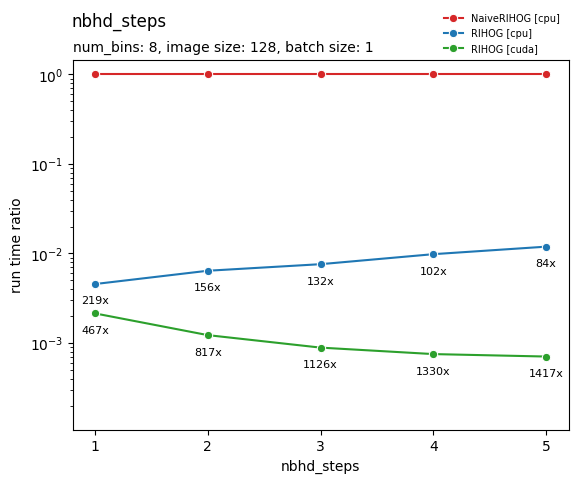

In [30]:
ax = sns.lineplot(df_nbhd_steps_rel, x="nbhd_steps", y="run time ratio", hue="algo", marker="o", palette=palette)
ax.set_yscale("log")
ax.set_xticks(df_nbhd_steps_rel["nbhd_steps"].unique())
ax.set_ylim(bottom=.5 * ylim_bottom, top=1.45)
plt.suptitle("nbhd_steps", x=.123, ha="left")
plt.title(f"num_bins: {NUM_BINS}, image size: {IMG_SIZE}, batch size: {BATCH_SIZE}", loc="left", fontsize=10)
plt.legend(title=None, fontsize=7, loc="upper right", bbox_to_anchor=(1,1.15), frameon=False)
for line in ax.lines[1:2+1]:
	for x, y in line.get_xydata():
		plt.text(x, .6*y, f"{round(1 / y)}x", fontsize=8, ha="center")

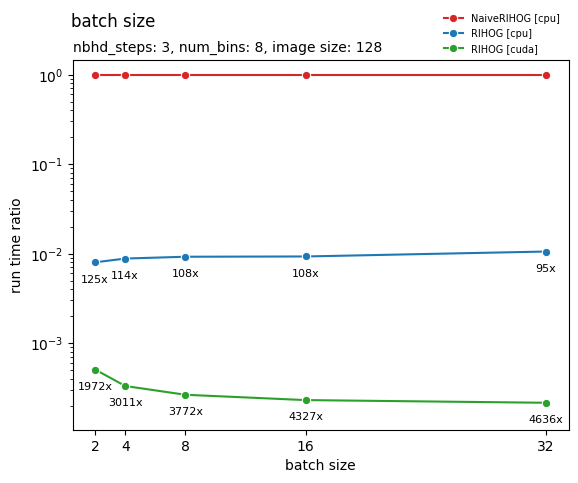

In [31]:
ax = sns.lineplot(df_batch_size_rel, x="batch size", y="run time ratio", hue="algo", marker="o", palette=palette)
ax.set_yscale("log")
ax.set_xticks(df_batch_size_rel["batch size"].unique())
ax.set_ylim(bottom=.5 * ylim_bottom, top=1.45)
plt.suptitle("batch size", x=.123, ha="left")
plt.title(f"nbhd_steps: {NBHD_STEPS}, num_bins: {NUM_BINS}, image size: {IMG_SIZE}", loc="left", fontsize=10)
plt.legend(title=None, fontsize=7, loc="upper right", bbox_to_anchor=(1,1.15), frameon=False)
for line in ax.lines[1:2+1]:
	for x, y in line.get_xydata():
		plt.text(x, .6*y, f"{round(1 / y)}x", fontsize=8, ha="center")

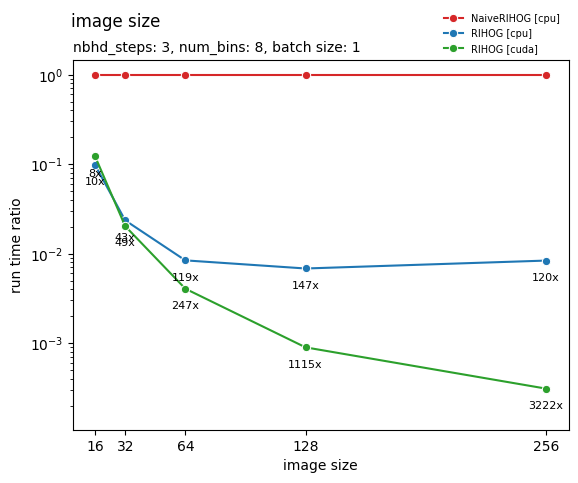

In [32]:
ax = sns.lineplot(df_img_size_rel, x="image size", y="run time ratio", hue="algo", marker="o", palette=palette)
ax.set_yscale("log")
ax.set_xticks(df_img_size_rel["image size"].unique())
ax.set_ylim(bottom=.5 * ylim_bottom, top=1.45)
plt.suptitle("image size", x=.123, ha="left")
plt.title(f"nbhd_steps: {NBHD_STEPS}, num_bins: {NUM_BINS}, batch size: {BATCH_SIZE}", loc="left", fontsize=10)
plt.legend(title=None, fontsize=7, loc="upper right", bbox_to_anchor=(1,1.15), frameon=False)
for line in ax.lines[1:2+1]:
	for x, y in line.get_xydata():
		plt.text(x, .6*y, f"{round(1 / y)}x", fontsize=8, ha="center")